In [ ]:
!pip install scanpy
!pip install matplotlib==3.6
!pip install louvain

In [ ]:
# Function adapted from scIB project at:
# https://github.com/theislab/scib-reproducibility/blob/main/visualization/embeddings_and_trajectories.ipynb
def get_root(adata_pre, adata_post, ct_key, dpt_dim=3):

    n_components, adata_post.obs['neighborhood'] = connected_components(csgraph=adata_post.obsp['connectivities'], directed=False, return_labels=True)

    start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
    min_dpt = adata_pre.obs[adata_pre.obs[ct_key] == start_clust].index
    max_neigh = adata_post.obs[adata_post.obs['neighborhood']== adata_post.obs['neighborhood'].value_counts().idxmax()].index
    min_dpt = [value for value in min_dpt if value in max_neigh]

    adata_post_sub = adata_post[adata_post.obs['neighborhood']== adata_post.obs['neighborhood'].value_counts().idxmax()]

    min_dpt = [adata_post_sub.obs_names.get_loc(i) for i in min_dpt]

    # compute Diffmap for adata_post
    sc.tl.diffmap(adata_post_sub)

    # determine most extreme cell in adata_post Diffmap
    min_dpt_cell = np.zeros(len(min_dpt))
    for dim in np.arange(dpt_dim):

        diffmap_mean = adata_post_sub.obsm["X_diffmap"][:, dim].mean()
        diffmap_min_dpt = adata_post_sub.obsm["X_diffmap"][min_dpt, dim]

        # choose optimum function
        if diffmap_min_dpt.mean() < diffmap_mean:
            opt = np.argmin
        else:
            opt = np.argmax
        # count opt cell
        if len(diffmap_min_dpt) == 0:
            #raise RootCellError('No root cell in largest component')
            return False
        min_dpt_cell[opt(diffmap_min_dpt)] += 1

    # root cell is cell with max vote
    adata_post_sub.uns['iroot'] = min_dpt[np.argmax(min_dpt_cell)]
    return adata_post_sub



def compute_pseudotime(integrated, orig, label_key, use_embedding=False):
    # Determine the repository for UMAP computation
    umap_key = 'X_emb' if use_embedding else None

    if use_embedding and 'X_emb' not in integrated.obsm.keys():
        raise ValueError("Embedding 'X_emb' not found in adata.obsm")

    # Compute neighbors using the specified representation
    sc.pp.neighbors(integrated, use_rep=umap_key)

    # Compute UMAP if it hasn't been already
    if 'X_umap' not in integrated.obsm.keys():
        sc.tl.umap(integrated)

    sc.tl.diffmap(integrated)
    integrated = get_root(orig, integrated, label_key)
    sc.tl.dpt(integrated)


def plot_umap_with_pseudotime(adata, ax, use_embedding=False, is_original_data=True):

    # Determine the repository for UMAP computation
    umap_key = 'X_emb' if use_embedding else None

    if use_embedding and 'X_emb' not in adata.obsm.keys():
        raise ValueError("Embedding 'X_emb' not found in adata.obsm")

    # Compute UMAP
    if 'X_umap' not in adata.obsm.keys() or use_embedding:
        sc.pp.neighbors(adata, use_rep=umap_key)
        sc.tl.umap(adata)

    # Extract UMAP data
    x, y = adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1]

    # Color by pseudotime
    pseudotime_colors = adata.obs['dpt_pseudotime']

    scatter = ax.scatter(x, y, c=pseudotime_colors, cmap='viridis', s=1)

    if is_original_data:
        cbar = plt.colorbar(scatter, ax=ax, pad=0.01, location='left')
        cbar.set_label('Pseudotime')

    # Add cell type annotations
    for cluster in adata.obs['final_annotation'].cat.categories:
        cluster_data = adata[adata.obs['final_annotation'] == cluster]
        centroid = np.mean(cluster_data.obsm['X_umap'], axis=0)
        ax.text(centroid[0], centroid[1], cluster, fontsize=9, ha='center', va='center')

    ax.set_title("UMAP colored by pseudotime")
    ax.set_xticks([])
    ax.set_yticks([])


def plot_umap_with_species_label(adata, ax, species_label_key,
                                 use_embedding=False, is_original_data=True):

    # Determine the repository for UMAP computation
    umap_key = 'X_emb' if use_embedding else None

    if use_embedding and 'X_emb' not in adata.obsm.keys():
        raise ValueError("Embedding 'X_emb' not found in adata.obsm")

    # Compute UMAP
    if 'X_umap' not in adata.obsm.keys() or use_embedding:
        sc.pp.neighbors(adata, use_rep=umap_key)
        sc.tl.umap(adata)

    # Extract UMAP data
    x, y = adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1]

    # Plot each species with different colors
    species_colors = {'Human': 'blue', 'Mouse': 'red'}

    # Plot each species with its assigned color
    for species, color in species_colors.items():
        species_mask = adata.obs[species_label_key] == species
        ax.scatter(x[species_mask], y[species_mask], label=species, color=color, s=1)


    # Add legend if it's original data
    if True:
        ax.legend(loc='lower left', bbox_to_anchor=(0.5, -0.05), ncol=2,
                  fontsize=8, markerscale=3)


    # annotate cell types
    for cluster in adata.obs['final_annotation'].cat.categories:
        cluster_data = adata[adata.obs['final_annotation'] == cluster]
        centroid = np.mean(cluster_data.obsm['X_umap'], axis=0)
        ax.text(centroid[0], centroid[1], cluster, fontsize=9, ha='center', va='center')

    ax.set_title("UMAP colored by species label")
    ax.set_xticks([])
    ax.set_yticks([])


def plot_umap_with_cell_type_label(adata, ax, cell_type_label_key, color_map = None, use_embedding=False, is_original_data=True):

    # Determine the repository for UMAP computation
    umap_key = 'X_emb' if use_embedding else None

    if use_embedding and 'X_emb' not in adata.obsm.keys():
        raise ValueError("Embedding 'X_emb' not found in adata.obsm")

    # Compute UMAP
    if 'X_umap' not in adata.obsm.keys() or use_embedding:
        sc.pp.neighbors(adata, use_rep=umap_key)
        sc.tl.umap(adata)

    # Extract UMAP data
    x, y = adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1]

    # Plot each cell type with its assigned color from the color map
    scatter_plots = []
    for cell_type in color_map:
        cell_type_mask = adata.obs[cell_type_label_key] == cell_type
        scatter = ax.scatter(x[cell_type_mask], y[cell_type_mask], label=cell_type, color=color_map[cell_type], s=1)
        scatter_plots.append(scatter)

    # Add legend if it's original data
    if True:
        # Determine the number of columns for the legend based on the number of cell types
        ncol = min(len(color_map), 1)

        # Create custom legend
        legend = ax.legend(handles=scatter_plots, loc='lower left',
                          #  bbox_to_anchor=(0.5, -0.3),
                           ncol=ncol, fontsize=8, markerscale=3)
        for handle in legend.legendHandles:
            handle.set_sizes([30])

    # Annotate cell types
    for cluster in adata.obs['final_annotation'].cat.categories:
        cluster_data = adata[adata.obs['final_annotation'] == cluster]
        centroid = np.mean(cluster_data.obsm['X_umap'], axis=0)
        ax.text(centroid[0], centroid[1], cluster, fontsize=9, ha='center', va='center')

    ax.set_title("UMAP colored by cell type label")
    ax.set_xticks([])
    ax.set_yticks([])



/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  ABC
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<ipython-input-18-48b52253827a>:151: ImplicitModificationWarning: Setting element `.obsm['X_emb']` of view, initializing view as actual.
  integ_data.obsm['X_emb'] = integ_data.X.copy()
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  scgen
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  AutoClass
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  CLEAR_embed
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  scanvi
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  scvi
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  scanorama
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


The given integ_data.X matrix is sparse. Converting to dense.
         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  harmony_embed
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  combat
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  scDREAMER_embed
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


--------------------------------------------------
Using dataset:  Immune_ALL_hum_mou
Evaluating method:  Seurat
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


The given integ_data.X matrix is sparse. Converting to dense.
         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
<ipython-input-9-d13ad470ffdd>:60: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  start_clust = adata_pre.obs.groupby([ct_key]).mean()['dpt_pseudotime'].idxmin()
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_dpt.py:18: ImplicitModificationWarning: Setting element `.obsm['X_diffmap']` of view, initializing view as actual.
  adata.obsm['X_diffmap'] = dpt.eigen_basis


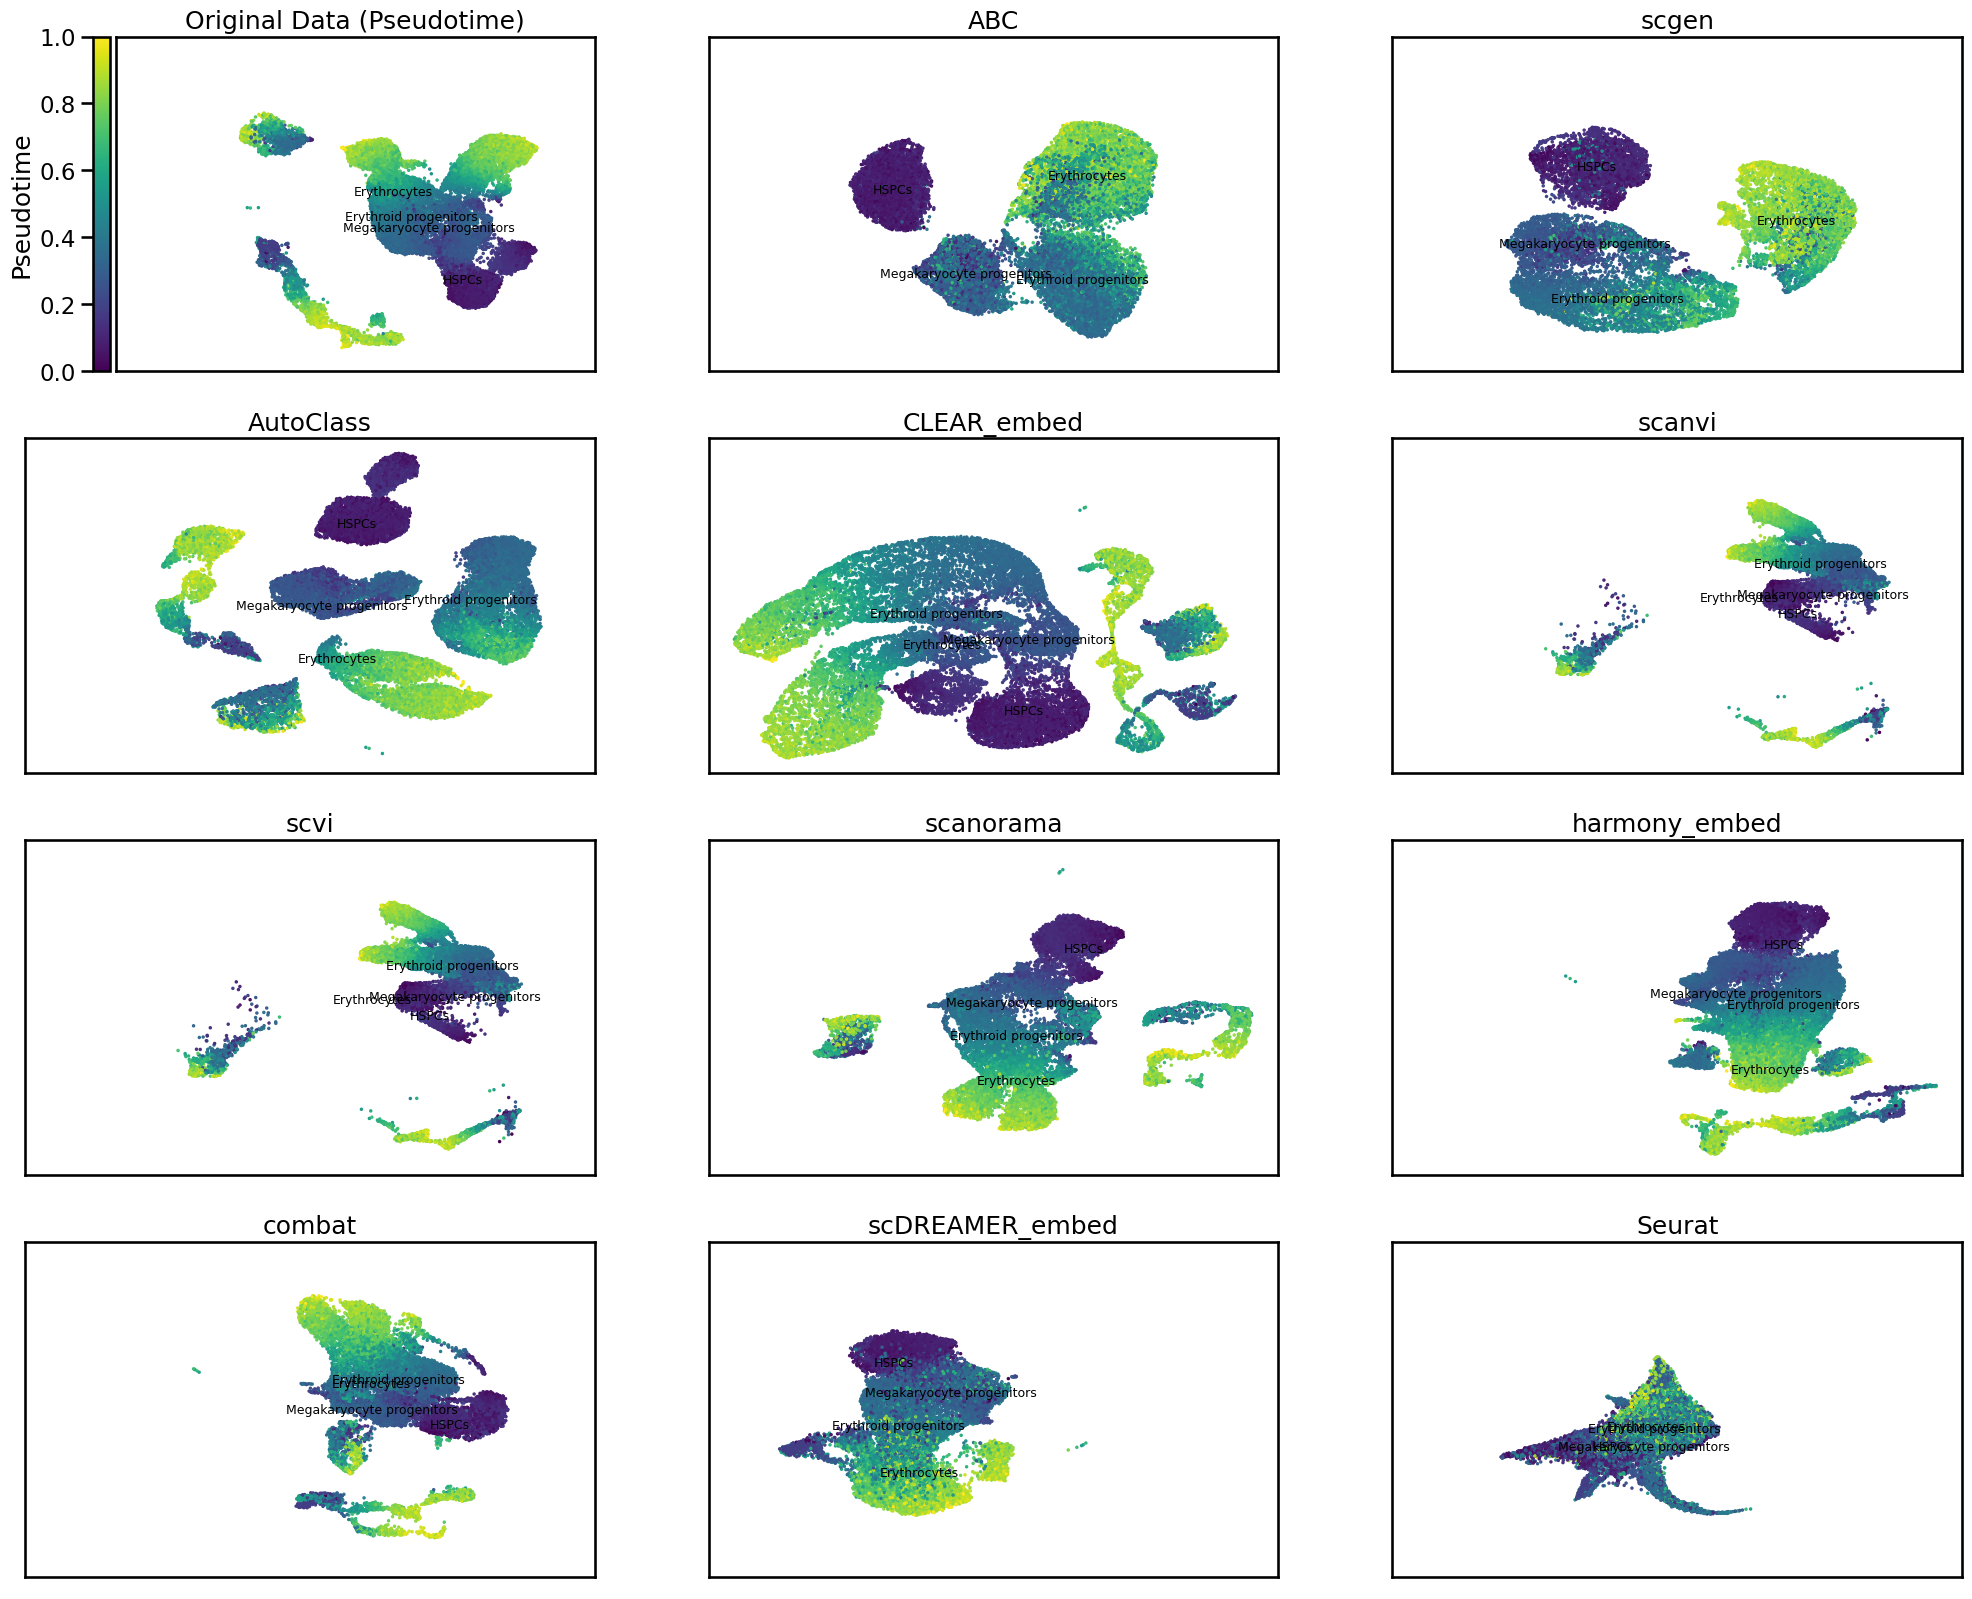

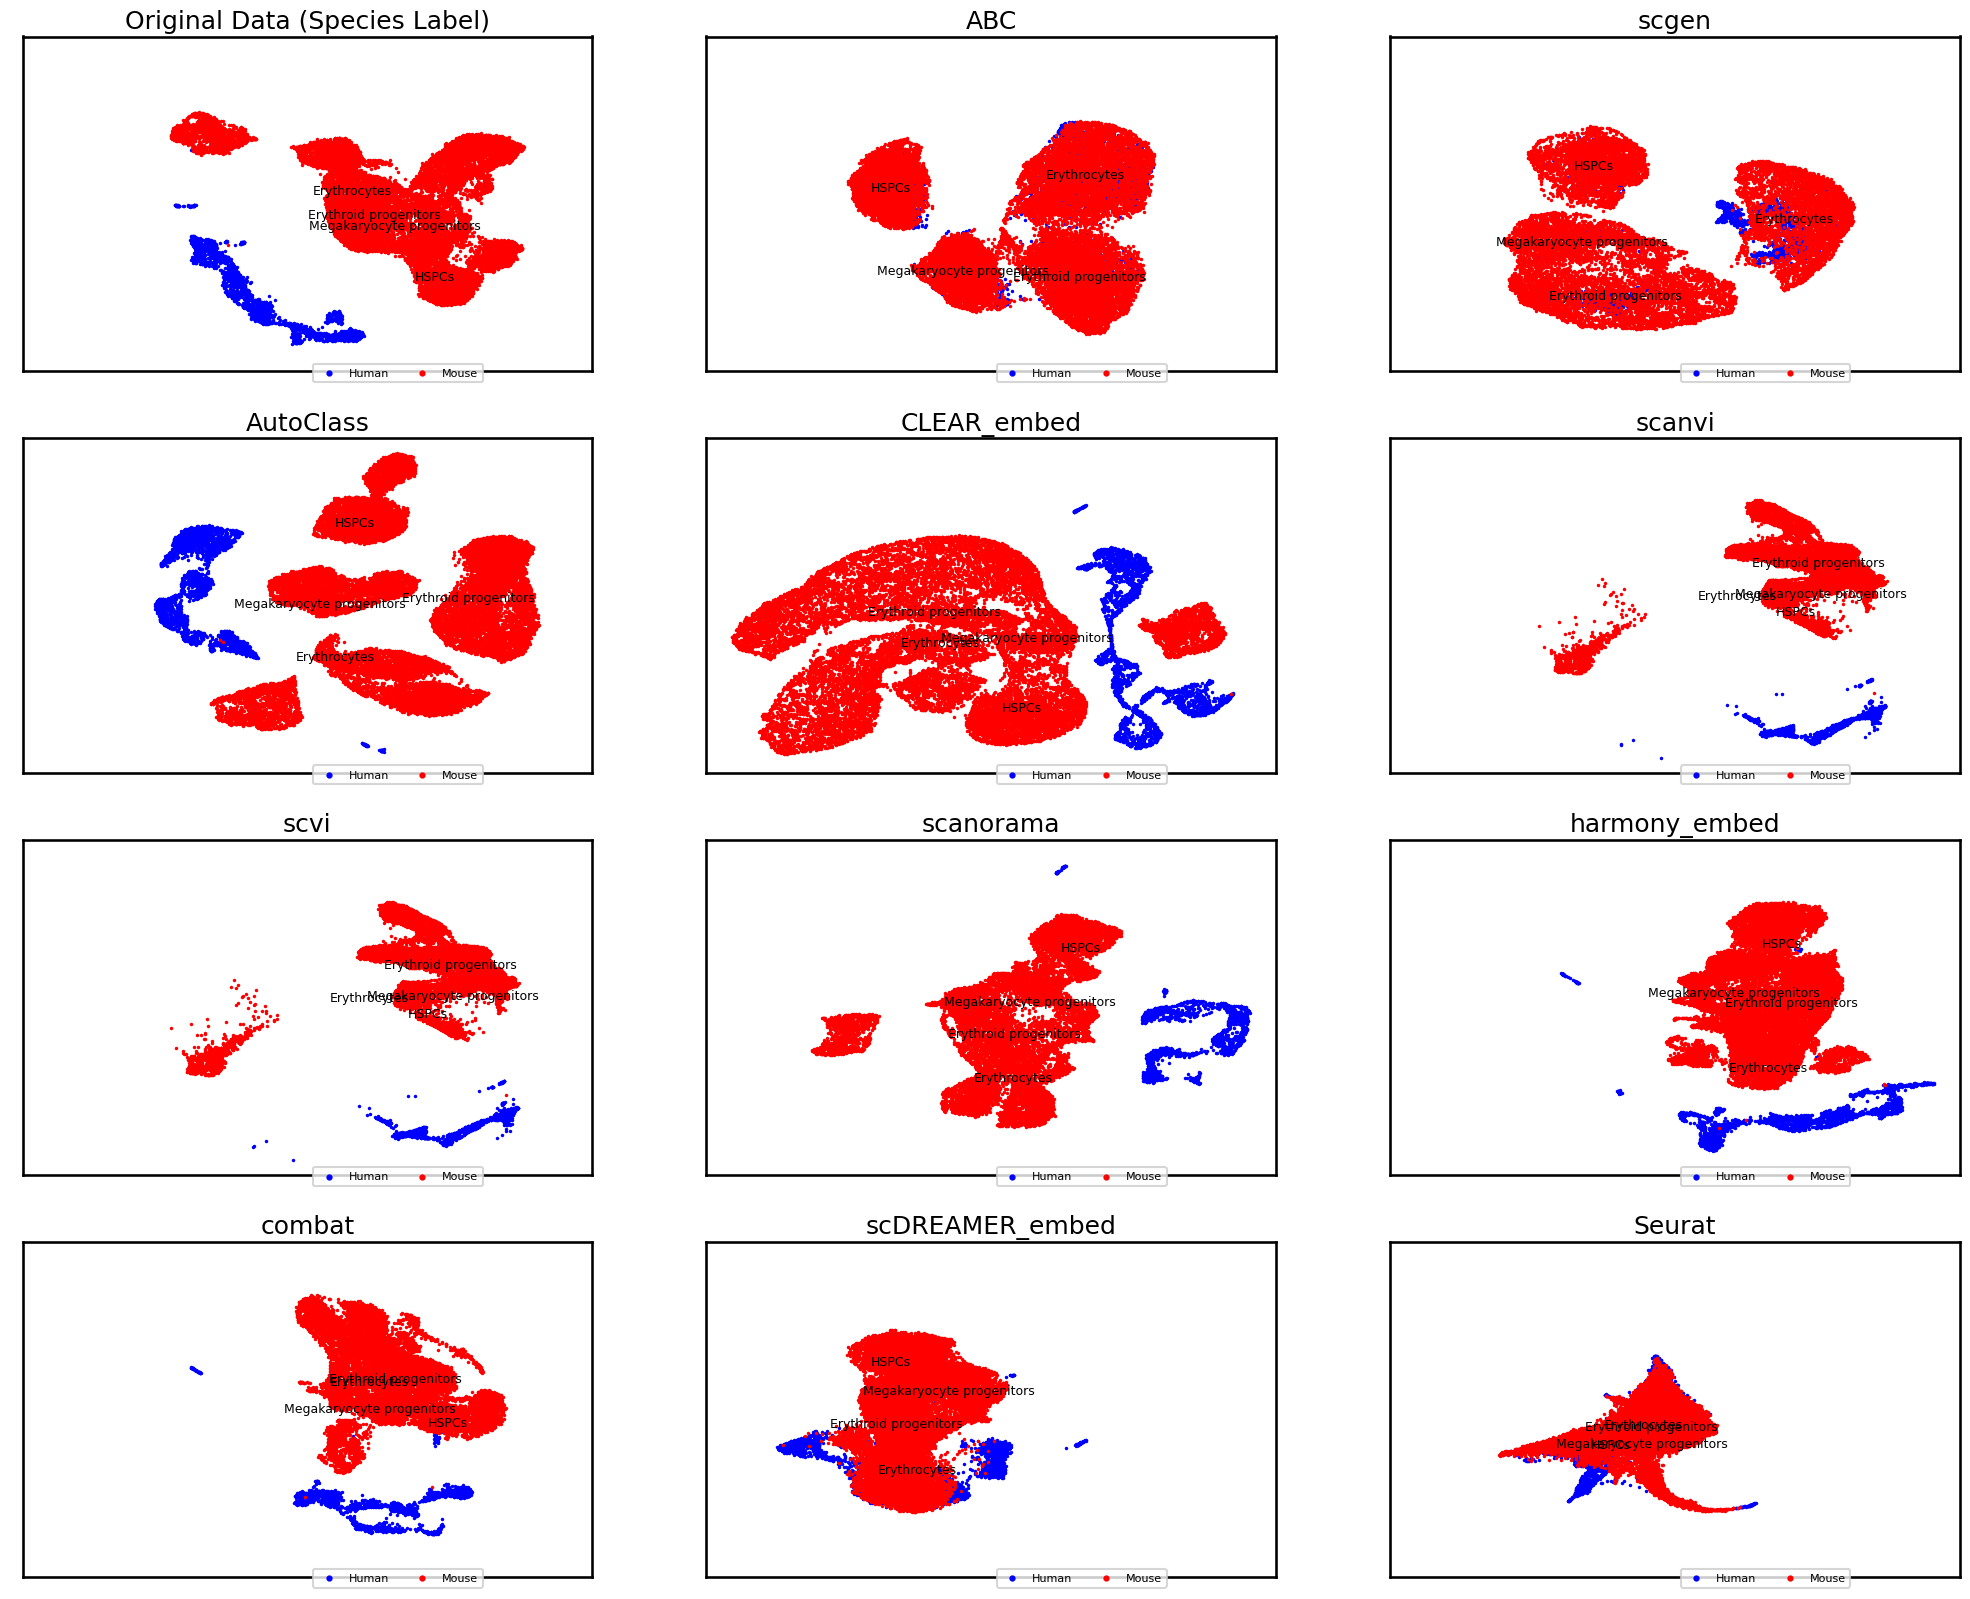

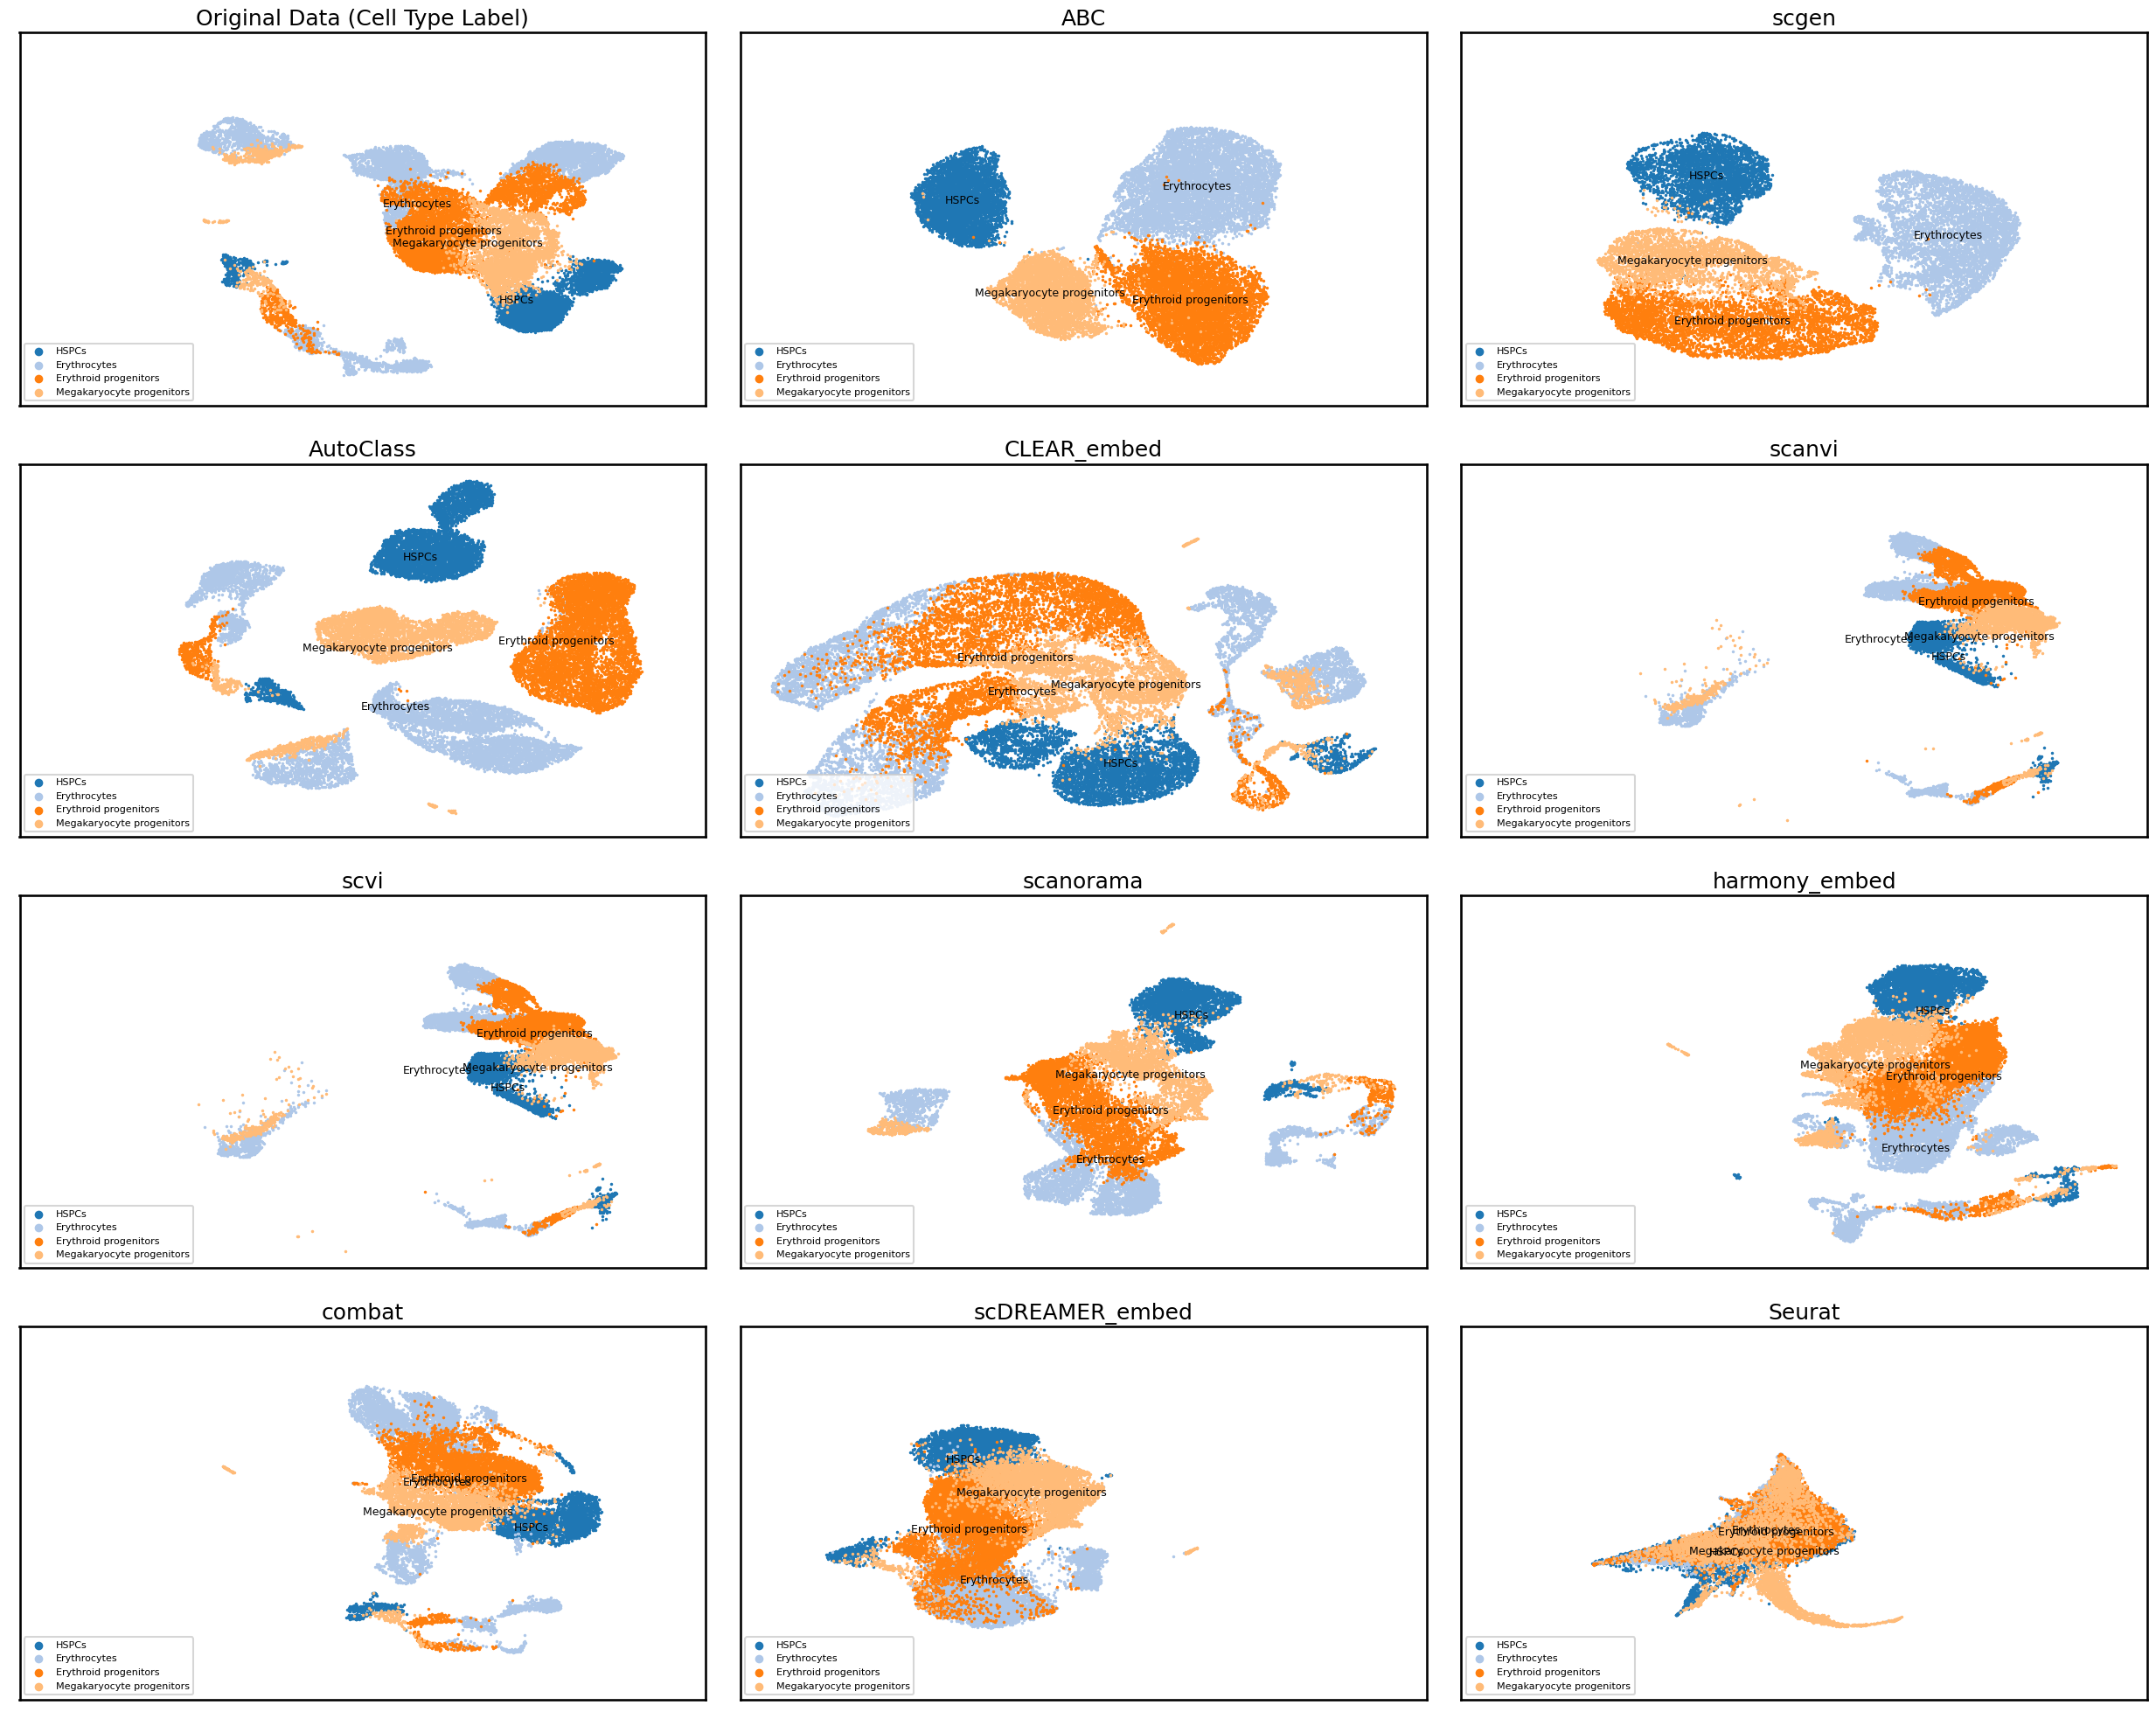

In [ ]:
import os
from pathlib import Path
import scipy
import random
import warnings
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/modules/')
from datasets_dict import datasets

# list of methods to evaluate - sorted by bio conservation score
methods = [
            'ABC',
            'scgen',
            'AutoClass',
            'CLEAR_embed',
            'scanvi',
            'scvi',
            'scanorama',
            'harmony_embed',
            'combat',
            'scDREAMER_embed',
            'Seurat',
            ]

embedding_methods = ['ABC', 'harmony_embed', 'scDREAMER_embed', 'CLEAR_embed']
selected_cell_types = ['HSPCs', 'Erythrocytes', 'Erythroid progenitors', 'Megakaryocyte progenitors']

# path to the original dataset (after subset to 3000 highly variable genes)
orig_base_path = '/content/drive/MyDrive/Colab Notebooks/integrationDatasets/'

# path to the metrics csv file
metrics_path = os.path.join(orig_base_path, 'final_metrics')

# create metrics folder if does not exist
Path(metrics_path).mkdir(parents=True, exist_ok=True)

dataset_name = "Immune_ALL_hum_mou"


# get dataset parameters from the dictionary
label_key = datasets[dataset_name]['label_key']
batch_key = datasets[dataset_name]['batch_key']
subsample = datasets[dataset_name]['subsample']
atac = datasets[dataset_name]['ATAC']
organism = datasets[dataset_name]['organism']

if atac:
  data_type = 'ATAC'
else:
  data_type = 'RNA'


# load original (unintegrated) dataset
orig_path = os.path.join(orig_base_path, f"{dataset_name}_hvg.h5ad")
orig_data = sc.read(orig_path)

# define cell type colors
color_map = {cell_type: color for cell_type, color in zip(selected_cell_types, plt.cm.tab20.colors)}


# make sure the data matrix is not sparse
if scipy.sparse.issparse(orig_data.X):
  print("The given adata.X matrix is sparse. Converting to dense.")
  orig_data.X = orig_data.X.todense()

# subset data to selected cell types
orig_data = orig_data[orig_data.obs[label_key].isin(selected_cell_types)]

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = (len(methods) + 1) // num_rows

# Create subplot grids
fig_pseudotime, axes_pseudotime = plt.subplots(num_rows, num_cols, figsize=(25, 20), sharex=True, sharey=True)
fig_species, axes_species = plt.subplots(num_rows, num_cols, figsize=(25, 20), sharex=True, sharey=True)
fig_types, axes_types = plt.subplots(num_rows, num_cols, figsize=(25, 20), sharex=True, sharey=True)

if num_rows > 1:
    axes_pseudotime = axes_pseudotime.flatten()
    axes_species = axes_species.flatten()
    axes_types = axes_types.flatten()


# Plot original data
plot_umap_with_pseudotime(orig_data, axes_pseudotime[0], is_original_data=True)
axes_pseudotime[0].set_title('Original Data (Pseudotime)')

plot_umap_with_species_label(orig_data, axes_species[0], species_label_key='species', is_original_data=True)
axes_species[0].set_title('Original Data (Species Label)')

plot_umap_with_cell_type_label(orig_data, axes_types[0], cell_type_label_key=label_key, color_map=color_map, is_original_data=True)
axes_types[0].set_title('Original Data (Cell Type Label)')


# Process and plot data for each method
for i, method in enumerate(methods):
    print('-' * 50)
    print("Using dataset: ", dataset_name)
    print("Evaluating method: ", method)
    print('-' * 50)
    use_embed = False

    # Set seed for reproducibility
    seed_value = 1
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # the hash seed for Python
    random.seed(seed_value)  # the seed for Python's built-in random module
    np.random.seed(seed_value)  # the seed for Numpy (which Scipy relies on)
    tf.random.set_seed(seed_value)  # the seed for TensorFlow


    # load integrated dataset
    integ_path = os.path.join(orig_base_path, "integratedDatasets",
                              method, f"{dataset_name}_integrated.h5ad")
    integ_data = sc.read(integ_path)


    # make sure data is not sparse
    if scipy.sparse.issparse(integ_data.X):
      print("The given integ_data.X matrix is sparse. Converting to dense.")
      integ_data.X = integ_data.X.todense()

    # subset to selected cell types
    integ_data = integ_data[integ_data.obs[label_key].isin(selected_cell_types)]

    # method specific data preparations
    if method == 'ABC':
      integ_data.obsm['X_emb'] = integ_data.X.copy()

    # fix gene names for Seurat naming convention
    if method == 'Seurat':

        # if the var names contain '_' instead of "-" - use the next lines to convert
        integ_data.var_names = [id.replace('-', '_') for id in integ_data.var_names]
        orig_data.var_names = [id.replace('-', '_') for id in orig_data.var_names]
        orig_data = orig_data[:, integ_data.var_names]

    # define output type
    if method in embedding_methods:
      use_embed = True

    compute_pseudotime(integ_data, orig_data, label_key,
                              use_embedding=use_embed)

    # Plot pseudotime
    plot_umap_with_pseudotime(integ_data, axes_pseudotime[i+1],
                              use_embedding=use_embed, is_original_data=False)
    axes_pseudotime[i+1].set_title(method)



    # Plot species label
    plot_umap_with_species_label(integ_data, axes_species[i+1],
                                 species_label_key='species',
                                 use_embedding=use_embed, is_original_data=False)
    axes_species[i+1].set_title(method)



    # Plot cell types label
    plot_umap_with_cell_type_label(integ_data, axes_types[i+1],
                                 cell_type_label_key=label_key,
                                 color_map=color_map,
                                 use_embedding=use_embed, is_original_data=False)
    axes_types[i+1].set_title(method)



# Display all sets of plots
plt.tight_layout()
fig_pseudotime.show()
fig_species.show()
fig_types.show()